# Deep Learning on Azure Databricks (with PyTorch)

Classical machine learning relies on using statistics to determine relationships between features and labels, and can be very effective for creating predictive models. However, a massive growth in the availability of data coupled with advances in the computing technology required to process it has led to the emergence of new machine learning techniques that mimic the way the brain processes information in a structure called an artificial neural network.

PyTorch is a framework for creating machine learning models, including deep neural networks (DNNs). In this example, we'll use PyTorch to create a simple neural network that classifies penguins into species based on the length and depth of their culmen (bill), their flipper length, and their body mass.

> **Citation**: The penguins dataset used in the this exercise is a subset of data collected and made available by [Dr. Kristen
Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php)
and the [Palmer Station, Antarctica LTER](https://pal.lternet.edu/), a
member of the [Long Term Ecological Research
Network](https://lternet.edu/).

## Explore the Dataset

Before we start using PyTorch to create a model, let's load the data we need from the Palmer Islands penguins dataset, which contains observations of three different species of penguin.

> **Note**: In reality, you can solve the penguin classification problem easily using classical machine learning techniques without the need for a deep learning model; but it's a useful, easy to understand dataset with which to demonstrate the principles of neural networks in this notebook.

In [0]:
%sh
rm -r /dbfs/data
mkdir /dbfs/data
wget -O /dbfs/data/penguins.csv https://raw.githubusercontent.com/MicrosoftLearning/dp-090-databricks-ml/master/data/penguins.csv

rm: cannot remove '/dbfs/data': No such file or directory
--2023-11-22 16:08:18--  https://raw.githubusercontent.com/MicrosoftLearning/dp-090-databricks-ml/master/data/penguins.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9878 (9.6K) [text/plain]
Saving to: ‘/dbfs/data/penguins.csv’

     0K .........                                             100% 2.05M=0.005s

2023-11-22 16:08:18 (2.05 MB/s) - ‘/dbfs/data/penguins.csv’ saved [9878/9878]



Now let's do some preprocessing to prepare the data for machine learning.

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

# Load the data, removing any incomplete rows
df = spark.read.format("csv").option("header", "true").load("/data/penguins.csv").dropna()

# Encode the Island with a simple integer index
# Scale FlipperLength and BodyMass so they're on a similar scale to the bill measurements
islands = df.select(collect_set("Island").alias('Islands')).first()['Islands']
island_indexes = [(islands[i], i) for i in range(0, len(islands))]
df_indexes = spark.createDataFrame(island_indexes).toDF('Island', 'IslandIdx')
data = df.join(df_indexes, ['Island'], 'left').select(col("IslandIdx"),
                   col("CulmenLength").astype("float"),
                   col("CulmenDepth").astype("float"),
                   (col("FlipperLength").astype("float")/10).alias("FlipperScaled"),
                   (col("BodyMass").astype("float")/100).alias("MassScaled"),
                   col("Species").astype("int")
                   )

# Oversample the dataframe to triple its size
# (Deep learning techniques like LOTS of data)
for i in range(1,3):
    data = data.union(data)
display(data.sample(0.1))

IslandIdx,CulmenLength,CulmenDepth,FlipperScaled,MassScaled,Species
0,39.5,16.7,17.8,32.5,0
0,37.6,19.3,18.1,33.0,0
0,40.8,18.4,19.5,39.0,0
0,36.0,18.5,18.6,31.0,0
0,39.6,18.1,18.6,44.5,0
0,40.8,18.9,20.8,43.0,0
0,40.7,17.0,19.0,37.25,0
0,52.7,19.8,19.7,37.25,2
0,46.4,18.6,19.0,34.5,2
0,49.2,18.2,19.5,44.0,2


The prepared data consists of a set of *features* (the encoded island where the penguin was observed and the scaled measurements of the penguin) and a *label* (a class ID indivcating the species of the penguin - 0=Adelie, 1=Gentoo, 3=Chinstrap).

We're going to train a *classification* model to predict the species of a penguin based on its features. As is common in a supervised learning problem such as classification, we'll split the dataset into a set of records with which to train the model, and a smaller set with which to validate the trained model. We'll borrow the **train_test_split** function from Scikit-Learn to do this.

In [0]:
from sklearn.model_selection import train_test_split

features = ['IslandIdx','CulmenLength','CulmenDepth','FlipperScaled','MassScaled']
label = 'Species'
   
# Split data 70%-30% into training set and test set
x_train, x_test, y_train, y_test = train_test_split(data.toPandas()[features].values,
                                                    data.toPandas()[label].values,
                                                    test_size=0.30,
                                                    random_state=0)

print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))


Training Set: 957, Test Set: 411 



The *features* are the measurements for each penguin observation, and the *label* is a numeric value that indicates the species of penguin that the observation represents (Adelie, Gentoo, or Chinstrap).

## Install and import the PyTorch libraries

Since we plan to use PyTorch to create our penguin classifier, we'll need to import the PyTorch libraries we intend to use. PyTorch is already installed on Azure databricks clusters with an ML Databricks runtime (the specific installation of of PyTorch depends on whether the cluster has graphics processing units (GPUs) that can be used for high-performance processing via *cuda*).

In [0]:
import torch
import torch.nn as nn
import torch.utils.data as td
import torch.nn.functional as F

# Set random seed for reproducability
torch.manual_seed(0)

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.0.1+cpu


## Prepare the data for PyTorch

PyTorch makes use of *data loaders* to load training and validation data in batches. We've already loaded the data into numpy arrays, but we need to wrap those in PyTorch datasets (in which the data is converted to PyTorch *tensor* objects) and create loaders to read batches from those datasets.

In [0]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=20,
    shuffle=False, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=20,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


## Define a neural network

Now we're ready to define our neural network. In this case, we'll create a network that consists of 3 fully-connected layers:
* An input layer that receives an input value for each feature (in this case, the island index and four penguin measurements) and generated 10 outputs.
* A hidden layer that receives ten inputs from the input layer and sends ten outputs to the next layer.
* An output layer that generates a non-negative numeric output for each penguin species (which a loss function will translate into classification probabilities for each of the three possible penguin species).

As we train the network by passing data through it, the **forward** function will apply *RELU* activation functions to each layer.

In [0]:
# Number of hidden layer nodes
hl = 10

# Define the neural network
class PenguinNet(nn.Module):
    def __init__(self):
        super(PenguinNet, self).__init__()
        self.fc1 = nn.Linear(len(features), hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, 3)

    def forward(self, x):
        fc1_output = torch.relu(self.fc1(x))
        fc2_output = torch.relu(self.fc2(fc1_output))
        y = self.fc3(fc2_output)
        return y

# Create a model instance from the network
model = PenguinNet()
print(model)

PenguinNet(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


## Train the model

To train the model, we need to repeatedly feed the training values forward through the network, use a loss function to calculate the loss, use an optimizer to backpropagate the weight and bias value adjustments, and validate the model using the test data we withheld.

To do this, we'll create a function to train and optimize the model, and function to test the model.

In [0]:
def train(model, data_loader, optimizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss += loss.item()

        # backpropagate
        loss.backward()
        optimizer.step()

    #Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
           
            
def test(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += loss_criteria(out, target).item()

            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()
            
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss



Now we'll call the **train** and **test** functions iteratively over 100 epochs, logging the loss and accuracy statistics for each epoch.

In [0]:
# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 100 epochs
epochs = 100
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set: Average loss: 0.914321
Validation set: Average loss: 0.766022, Accuracy: 363/411 (88%)

Epoch: 2
Training set: Average loss: 0.683300
Validation set: Average loss: 0.623639, Accuracy: 388/411 (94%)

Epoch: 3
Training set: Average loss: 0.568967
Validation set: Average loss: 0.515932, Accuracy: 397/411 (97%)

Epoch: 4
Training set: Average loss: 0.459753
Validation set: Average loss: 0.406802, Accuracy: 401/411 (98%)

Epoch: 5
Training set: Average loss: 0.351169
Validation set: Average loss: 0.305127, Accuracy: 401/411 (98%)

Epoch: 6
Training set: Average loss: 0.256812
Validation set: Average loss: 0.223568, Accuracy: 401/411 (98%)

Epoch: 7
Training set: Average loss: 0.186547
Validation set: Average loss: 0.166399, Accuracy: 402/411 (98%)

Epoch: 8
Training set: Average loss: 0.138832
Validation set: Average loss: 0.128014, Accuracy: 404/411 (98%)

Epoch: 9
Training set: Average loss: 0.107275
Validation set: Average loss: 0.102244, Accuracy: 404/411 (98%)

E

While the training process is running, let's try to understand what's happening:

1. In each *epoch*, the full set of training data is passed forward through the network. There are five features for each observation, and five corresponding nodes in the input layer - so the features for each observation are passed as a vector of five values to that layer. However, for efficiency, the feature vectors are grouped into batches; so actually a matrix of multiple feature vectors is fed in each time.
2. The matrix of feature values is processed by a function that performs a weighted sum using initialized weights and bias values. The result of this function is then processed by the activation function for the input layer to constrain the values passed to the nodes in the next layer.
3. The weighted sum and activation functions are repeated in each layer. Note that the functions operate on vectors and matrices rather than individual scalar values. In other words, the forward pass is essentially a series of nested linear algebra functions. This is the reason data scientists prefer to use computers with graphical processing units (GPUs), since these are optimized for matrix and vector calculations.
4. In the final layer of the network, the output vectors contain a calculated value for each possible class (in this case, classes 0, 1, and 2). This vector is processed by a *loss function* that converts these values to probabilities and determines how far they are from the expected values based on the actual classes - so for example, suppose the output for a Gentoo penguin (class 1) observation is \[0.3, 0.4, 0.3\]. The correct prediction would be \[0.0, 1.0, 0.0\], so the variance between the predicted and actual values (how far away each predicted value is from what it should be) is \[0.3, 0.6, 0.3\]. This variance is aggregated for each batch and maintained as a running aggregate to calculate the overall level of error (*loss*) incurred by the training data for the epoch. 
5. At the end of each epoch, the validation data is passed through the network, and its loss and accuracy (proportion of correct predictions based on the highest probability value in the output vector) are also calculated. It's useful to do this because it enables us to compare the performance of the model after each epoch using data on which it was not trained, helping us determine if it will generalize well for new data or if it's *overfitted* to the training data.
6. After all the data has been passed forward through the network, the output of the loss function for the *training* data (but <u>not</u> the *validation* data) is passed to the opimizer. The precise details of how the optimizer processes the loss vary depending on the specific optimization algorithm being used; but fundamentally you can think of the entire network, from the input layer to the loss function as being one big nested (*composite*) function. The optimizer applies some differential calculus to calculate *partial derivatives* for the function with respect to each weight and bias value that was used in the network. It's possible to do this efficiently for a nested function due to something called the *chain rule*, which enables you to determine the derivative of a composite function from the derivatives of its inner function and outer functions. You don't really need to worry about the details of the math here (the optimizer does it for you), but the end result is that the partial derivatives tell us about the slope (or *gradient*) of the loss function with respect to each weight and bias value - in other words, we can determine whether to increase or decrease the weight and bias values in order to minimize the loss.
7. Having determined in which direction to adjust the weights and biases, the optimizer uses the *learning rate* to determine by how much to adjust them; and then works backwards through the network in a process called *backpropagation* to assign new values to the weights and biases in each layer.
8. Now the next epoch repeats the whole training, validation, and backpropagation process starting with the revised weights and biases from the previous epoch - which hopefully will result in a lower level of loss.
9. The process continues like this for 100 epochs.

## Review training and validation loss

After training is complete, we can examine the loss metrics we recorded while training and validating the model. We're really looking for two things:
* The loss should reduce with each epoch, showing that the model is learning the right weights and biases to predict the correct labels.
* The training loss and validation loss should follow a similar trend, showing that the model is not overfitting to the training data.

Let's plot the loss metrics and see:

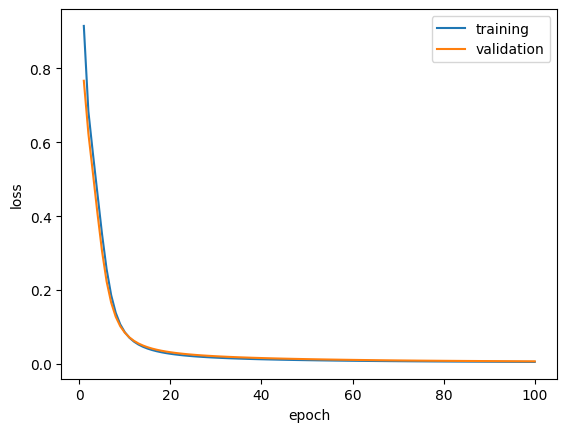

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## View the learned weights and biases

The trained model consists of the final weights and biases that were determined by the optimizer during training. Based on our network model we should expect the following values for each layer:
* Layer 1 (*fc1*): There are five input values going to ten output nodes, so there should be 10 x 5 weights and 10 bias values.
* Layer 2 (*fc2*): There are ten input values going to ten output nodes, so there should be 10 x 10 weights and 10 bias values.
* Layer 3 (*fc3*): There are ten input values going to three output nodes, so there should be 3 x 10 weights and 3 bias values.

In [0]:
for param_tensor in model.state_dict():
    print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())

fc1.weight 
 [[-3.34820780e-03  2.39904866e-01 -3.68076980e-01 -3.29121947e-01
  -1.72246262e-01]
 [ 8.89803886e-01  3.84012028e-03  4.49562579e-01  7.90952817e-02
   2.01856077e-01]
 [-1.35153800e-01 -8.79067108e-02 -4.27244842e-01 -2.96181560e-01
  -1.84351772e-01]
 [-5.72082996e-01  2.46854872e-01  5.86203039e-01 -3.01988900e-01
  -2.67089307e-01]
 [-3.92263263e-01  4.80195880e-01 -3.53530258e-01  3.46690118e-01
   1.07539184e-01]
 [-8.38775814e-01  4.88648325e-01 -6.11037195e-01 -3.10134232e-01
  -1.08117925e-03]
 [-1.36369145e+00  4.97936755e-01 -2.42426932e-01 -2.13567242e-01
  -2.80853450e-01]
 [ 4.13216144e-01 -3.48256081e-01  6.91559792e-01  2.23198742e-01
   4.53705601e-02]
 [ 2.35196613e-02 -2.29279026e-01  7.56616890e-02 -4.17560965e-01
  -3.23141456e-01]
 [-3.38578612e-01  2.00537995e-01  6.15359306e-01 -2.83804268e-01
  -2.31030717e-01]]
fc1.bias 
 [ 0.28602025  0.6469174   0.1774911   0.14008881  0.10035768 -0.4691967
 -0.01287484 -0.09644347 -0.30995753 -0.11539125]
fc2

## Save the trained model
Now that we have a trained model, we can save its trained weights for use later.

In [0]:
# Save the model weights
model_file = '/dbfs/penguin_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as /dbfs/penguin_classifier.pt


## Use the trained model

When we have a new penguin observation, we can use the model to predict the species.

In [0]:
# New penguin features
x_new = [[1, 50.4,15.3,20,50]]
print ('New sample: {}'.format(x_new))

# Create a new model class and load weights
model = PenguinNet()
model.load_state_dict(torch.load(model_file))

# Set model to evaluation mode
model.eval()

# Get a prediction for the new data sample
x = torch.Tensor(x_new).float()
_, predicted = torch.max(model(x).data, 1)

print('Prediction:',predicted.item())

New sample: [[1, 50.4, 15.3, 20, 50]]
Prediction: 1


## Distribute training with Horovod

The previous model training was performed on a single node of the cluster. In practice, it's generally better to scale deep learning model training across multiple CPUs (or preferably GPUs) on a single computer, but in some cases where you need to pass large volumes of training data through multiple layers of a deep learming model, you might achieve some efficiencies by distributing the training work across multiple cluster nodes.

Horovod is an open source library that you can use to distribute deep learning training across multiple nodes in a Spark cluster; such as those provisioned in an Azure Databricks workspace.

### Create a training function

To use Horovod, you encapsulate the code to configure training settings and call your **train** function in a new function; which you will run using the **HorovodRunner** class to distribute execution across multiple nodes. In your training wrapper function, you can make use of various Horovod classes to define a distributed data loader so each node can work on a subset of the overall dataset), broadcast the initial state of the model weights and optimizer to all of the nodes, identify how many nodes are being used, and determine which node code is running on.

In [0]:
import horovod.torch as hvd
from sparkdl import HorovodRunner

def train_hvd(model):
    from torch.utils.data.distributed import DistributedSampler
    
    hvd.init()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device.type == 'cuda':
        # Pin GPU to local rank
        torch.cuda.set_device(hvd.local_rank())
    
    # Configure the sampler so that each worker gets a distinct sample of the input dataset
    train_sampler = DistributedSampler(train_ds, num_replicas=hvd.size(), rank=hvd.rank())
    # Use train_sampler to load a different sample of data on each worker
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=20, sampler=train_sampler)
    
    # The effective batch size in synchronous distributed training is scaled by the number of workers
    # Increase learning_rate to compensate for the increased batch size
    learning_rate = 0.001 * hvd.size()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Wrap the local optimizer with hvd.DistributedOptimizer so that Horovod handles the distributed optimization
    optimizer = hvd.DistributedOptimizer(optimizer, named_parameters=model.named_parameters())

    # Broadcast initial parameters so all workers start with the same parameters
    hvd.broadcast_parameters(model.state_dict(), root_rank=0)
    hvd.broadcast_optimizer_state(optimizer, root_rank=0)

    optimizer.zero_grad()

    # Train over 100 epochs
    epochs = 100
    for epoch in range(1, epochs + 1):
        print('Epoch: {}'.format(epoch))
        # Feed training data into the model to optimize the weights
        train_loss = train(model, train_loader, optimizer)

    # Save the model weights
    print('rank',hvd.rank())
    if hvd.rank() == 0:
        model_file = '/dbfs/penguin_classifier_hvd.pt'
        torch.save(model.state_dict(), model_file)
        print('model saved as', model_file)

/databricks/python/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Run the training function on multiple nodes

Now you can use the **HorovodRunner** object to run your distributed training function on multiple worker nodes.

In [0]:
# Reset random seed for PyTorch
torch.manual_seed(0)

# Create a new model
new_model = PenguinNet()

# We'll use CrossEntropyLoss to optimize a multiclass classifier
loss_criteria = nn.CrossEntropyLoss()

# Run the distributed training function on 2 nodes
hr = HorovodRunner(np=4, driver_log_verbosity='all') 
hr.run(train_hvd, model=new_model)

# Load the trained weights and test the model
test_model = PenguinNet()
test_model.load_state_dict(torch.load('/dbfs/penguin_classifier_hvd.pt'))
test_loss = test(test_model, test_loader)

INFO:HorovodRunner:The global names read or written to by the pickled function are {'hvd': None, 'torch': None, 'train_ds': None, 'range': None, 'print': None, 'train': None}.
INFO:HorovodRunner:The pickled object size is 35682 bytes.
INFO:HorovodRunner:
### How to enable Horovod Timeline? ###
HorovodRunner has the ability to record the timeline of its activity with Horovod  Timeline. To
record a Horovod Timeline, set the `HOROVOD_TIMELINE` environment variable  to the location of the
timeline file to be created. You can then open the timeline file  using the chrome://tracing
facility of the Chrome browser.

INFO:HorovodRunner:Start training.


[1,1]<stderr>:/databricks/python/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
[1,1]<stderr>:  "class": algorithms.Blowfish,
[1,3]<stderr>:/databricks/python/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
[1,3]<stderr>:  "class": algorithms.Blowfish,
[1,2]<stderr>:/databricks/python/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
[1,2]<stderr>:  "class": algorithms.Blowfish,
[1,0]<stderr>:/databricks/python/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
[1,0]<stderr>:  "class": algorithms.Blowfish,
[1,0]<stderr>:/sbin/ldconfig.real: Renaming of /etc/ld.so.cache~ to /etc/ld.so.cache failed: No such file or directory
[1,0]<stdout>:Epoch: 1
[1,2]<stdout>:Epoch: 1
[1,1]<stdout>:Epoch: 1
[1,3]<stdout>:Epoch: 1
[1,2]

In [0]:
test_loss

0.007238732497517915

You may need to scroll to see all of the output, which should display some informational messages from Horovod followed by the logged output from the nodes (because the **driver_log_verbosity** parameter is set to **all**). The node outputs should show the loss after each epoch. Finally, the **test** function is used to test the trained model.

> **Tip**: If the loss does not reduce after each epoch, try running the cell again!

In this notebook, you explored the basics of deep learning with PyTorch on Azure Databricks. In reality, deep learning models are generally used to perform complex machine learning tasks such as training computer vision and natural language processing models; but this simple example should have familiarized you with the basic principles of how a deep neural network (DNN) model works.